In [1]:
%matplotlib inline

import numpy as np # NUMPY
import pandas as pd # PANDAS
import matplotlib.pyplot as plt # MATPLOTLIB
import seaborn as sns # SEABORN
import scipy
import sklearn
import random as rd
from sklearn.decomposition import PCA
from IPython.display import display
import cv2
import os 
from pathlib import Path
from random import randint
from scipy.linalg import norm
from math import atan

In [ ]:
###Aca vamos a sacar los b de textura

### primero agarramos la imagenes y las poneemos en array

In [2]:

subjects_images = '../ck+copy/extended-cohn-kanade-images/cohn-kanade-images'
sorted_subjects =   np.sort(os.listdir('../ck+copy/extended-cohn-kanade-images/cohn-kanade-images/')) # we probably need to not have the sorted

images = []

for subject in sorted_subjects:
    one_subject_images = '../ck+copy/extended-cohn-kanade-images/cohn-kanade-images/' + str(subject)+ '/'
    sorted_list = np.sort(os.listdir(one_subject_images)) #creo que este sort se puede quitar
    images_per_subject = []
    for emotion in sorted_list:
        images__per_seqframe = []
        subject_image_emotion = one_subject_images + str(emotion)
        for i in range(0, len(os.listdir(subject_image_emotion))):
            image = '../ck+copy/extended-cohn-kanade-images/cohn-kanade-images/' +  str(subject)+ '/' + str(emotion)+'/'+ str(subject)+ '_'+str(emotion)+'_'+ str(i+1).zfill(8)+'.png'
            images__per_seqframe.append(image)        
        images_per_subject.append(images__per_seqframe)
    images.append(images_per_subject)   
       

In [3]:
for i in range(0, len(images)):
    for j in range(0, len(images[i])):
                images[i][j]= np.asarray( images[i][j], dtype=object)
    images[i]= np.asarray( images[i], dtype=object)
images= np.asarray( images, dtype=object)

In [4]:
all_images = []
for i in range(0, len(images)):
    for j in range(0, len(images[i])):
        for r in range(0, len(images[i][j])):
            all_images.append(images[i][j][r])
        
        
all_images = np.asarray(all_images)
all_images.shape
#    stacked_array.append(np.vstack(tuple(images[i])))
#stacked_array= np.asarray( stacked_array, dtype=object)
#total_stacked_landmarkRawData = np.vstack(tuple(stacked_array))
#print(total_stacked_landmarkRawData.shape)

(965,)

In [5]:
#See if loading image works
img= cv2.imread(images[0][0][0])

img =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_width, img_height = img.shape
print(img.shape)

cv2.imshow("Face landmark result", img)

# Pause screen to wait key from user to see result
cv2.waitKey(0)
cv2.destroyAllWindows()

(490, 640)


### aca trate de alinear para el warp usando los ojos usando affine transformation, que usa 3 puntos,  y luego Delaunay triangulation para los 68, pero en el paper usan procustres que podemos usar para los 68 directamente, asi que luego de darme cuenta empeze con eso. Aca dejo este pedazo igual por ahora (falta delaunay)

In [5]:
#por ahora usamos numeros enteros, alineo los ojos a una altura y ancho
left_eye_warp = np.array([ 0.3 * img_width, float(round(img_height / 3 ))]) 
right_eye_warp =np.array([ 0.7 * img_width , float(round(img_height / 3 ))])

In [6]:
#Equilateral triangle
def equilateral_point(left, right):
    X, Y = left, right
    M = (X + Y) / 2
    O = (X - M) * 3**0.5
    t = np.array([[0, -1], [1, 0]])   # 90 degree transformation matrix

    thrid_point = M + O @ t
    return thrid_point
#
#In []:
#M + O @ t

#Out[]:
#array([1.5      , 1.8660254])

#In []:
#M + O @ t.T                       # the transpose gives -90

#Out[]:
#array([1.5      , 0.1339746])

In [7]:
third_point = equilateral_point(left_eye_warp, right_eye_warp)
third_point

array([245.        , 382.74097914])

In [9]:
right_eye_warp

array([343., 213.])

landmark_37(point 36) y landmark 46(45) son los corners de los ojos. Para mejor transformaciones usamos los landmarks intercalados

In [6]:
my_landmarks = pd.read_csv('ckmock_landmark_intercalated_data.csv',header = None)

In [9]:
even = np.asarray(my_landmarks.iloc[0][::2] )
odds = np.asarray( my_landmarks.iloc[0][1::2] )



left_eye_corner = np.array([even[36], odds[36]])
right_eye_corner = np.array([even[45], odds[45]])


third_point_corner = equilateral_point(left_eye_corner, right_eye_corner)



In [10]:
rows = 490
cols = 640
input_pts =  np.float32([left_eye_corner, right_eye_corner, third_point_corner])
output_pts =  np.float32([left_eye_warp, right_eye_warp, third_point])
M = cv2.getAffineTransform(input_pts , output_pts)
 
# Apply the affine transformation using cv2.warpAffine()
dst = cv2.warpAffine(img, M, (cols,rows))
 
# Display the image
out = cv2.hconcat([img, dst])
cv2.imshow('Output', out)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
lan =[]
for (a, b) in zip(even, odds):
    lan.append([[a,b]])
    
#np.array([ [[x1, y1]], ..., [[xn, yn]] ])
#dst=(np.dot(M[:,:2], a.T)+M[:,2].reshape(2,1)).T
lan =np.asarray(lan)
transformed_landmarks = cv2.transform(lan, M)

In [13]:
transformed_landmarks[0][0]

array([100.37205186, 223.13833075])

In [14]:
lan[0][0]

array([245.688  , 252.45154])

In [15]:
#Lets draw the landmarks in the image before and after the warp
for landmark in lan:
    x, y = landmark[0][0], landmark[0][1]
    cv2.circle(img, (int(x),int(y)), 1 , (255,0,0), -1)


In [ ]:
cv2.imshow('Output', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [20]:
for landmark in transformed_landmarks:
    x, y = landmark[0][0], landmark[0][1]
    cv2.circle(dst, (int(x),int(y)), 1 , (255,0,0), -1)


In [21]:
cv2.imshow('Output', dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Ahora vamos a hacerlo para todas las imagenes.
Y luego vamos a ver lo de los restos de los puntos



In [ ]:
#los puntos a coordinar
left_eye_warp, right_eye_warp, third_point
rows, cols #(490,640)
all_images

In [34]:
my_landmarks.shape

(965, 136)

In [39]:
transformed_landmarks_total = []
for i in range(0, len(my_landmarks)):
    even = np.asarray(my_landmarks.iloc[i][::2] )
    odds = np.asarray( my_landmarks.iloc[i][1::2] )
    left_eye_corner = np.array([even[36], odds[36]])
    right_eye_corner = np.array([even[45], odds[45]])
    third_point_corner = equilateral_point(left_eye_corner, right_eye_corner)

    input_pts =  np.float32([left_eye_corner, right_eye_corner, third_point_corner])
    output_pts =  np.float32([left_eye_warp, right_eye_warp, third_point])
    M = cv2.getAffineTransform(input_pts , output_pts)
    load_img = cv2.imread(all_images[i])
    dst = cv2.warpAffine(load_img, M, (cols,rows))
    lan =[]
    for (a, b) in zip(even, odds):
        lan.append([[a,b]])
    lan =np.asarray(lan)
    transformed_landmarks = cv2.transform(lan, M)
    transformed_landmarks_total.append(transformed_landmarks)
    filename = 'warped_image'+ str(i) + '.png'
    path = '../ck+warped'
    cv2.imwrite(os.path.join(path , filename), dst)
  
      
transformed_landmarks_total = np.asarray(transformed_landmarks_total) 

In [65]:
transformed_landmarks_total.shape

(965, 68, 1, 2)

In [68]:
965*136

131240

In [71]:
transformed_landmarks_total =transformed_landmarks_total.flatten().reshape((965,136))
transformed_landmarks_total.shape

my_df = pd.DataFrame(transformed_landmarks_total)
my_df.to_csv('transformed_landmarks_total.csv',header = False, index= False)

In [35]:
(deberriamos centrarlas tambien, pero al menos estan alineadas)

'../ck+copy/extended-cohn-kanade-images/cohn-kanade-images/S014/001/S014_001_00000011.png'

In [82]:
mean_landmark_points = transformed_landmarks_total.mean(axis = 0)
mean_landmark_points.shape

(136,)

In [95]:
even = np.asarray(mean_landmark_points[::2] )
odds = np.asarray( mean_landmark_points[1::2] )
lan =[]
for (a, b) in zip(even, odds):
    lan.append([a,b])
len(lan)

68

In [92]:
tri = scipy.spatial.Delaunay(lan, furthest_site=False, incremental=False, qhull_options=None)

tri.simplices.shape

(111, 3)

In [ ]:
we warp all the training face images to a
reference shape using cubic polynomial function

In [ ]:
For that, we first load the landmarks of the procustres analysis
used before as the references points for the warp 
(we use the intercalated ones as for now)


In [ ]:
Ahora vamos a hacer el wrap de todas las imagenes

In [ ]:
Por ahora estoy usando la misma imagen que en procustres. Deberia usar generalizado para hallar la de menor diferencia y usar esta

In [ ]:
#Procustres

In [7]:



        
def opa(a, b):# a, b matrices de puntos [[],[],[]] a and b need to have same dimension
    aT = a.mean(0) # column mean [[1,2,3],[1,2,3]]<-(1,2,3)
    bT = b.mean(0)
    A = a - aT  #We rest aT and bT to center the matrix (translation)
    B = b - bT
    aS = np.sum(A * A)**.5 #to see the scale, we first calculate square of squared sum
    bS = np.sum(B * B)**.5
    A /= aS  #we standarize the scale.
    B /= bS
    U, _, V = np.linalg.svd(np.dot(B.T, A)) # we get the principal values of the mult for getting the rotation more close 
    aR = np.dot(U, V) #<-the rotation matrix is the multiplication of these 2
    if np.linalg.det(aR) < 0: # we rotate to the positive side
        V[1] *= -1
        aR = np.dot(U, V)
    aS = aS / bS  #to scale A most similar to B, we divide the scale by sSvale
    aT-= (bT.dot(aR) * aS) #to get the translation in B coordinates, rest b mean rotated to A, and scaled to A 
    aD = (np.sum((A - B.dot(aR))**2) / len(a))**.5  # the square distance (error)of the A and B rotated after scale and translation
    return aR, aS, aT, aD #return aROtation, aScale, aTranslation, Adifference
        
def gpa(v, n=-1): #v is vector of images, n indicates index to reflect
    if n < 0: 
        p = avg(v)
    else:
        p = v[n]
    l = len(v) #quantity of images
    r, s, t, d = np.ndarray((4, l), object) #4 array of len l, each a matrix
    for i in range(l):
        r[i], s[i], t[i], d[i] = opa(p, v[i]) 
    return r, s, t, d#<-calculates the matrix and the error for all images, you use the one with the smallest one (can iterate this)

def avg(v): #given a vector of images, calculates average shape of images 
    v_= np.copy(v)
    l = len(v_) 
    R, S, T = [list(np.zeros(l)) for _ in range(3)]
    for i, j in np.ndindex(l, l): #hace la daptacion de cada i para cada j
        r, s, t, _ = opa(v_[i], v_[j]) 
        R[j] += np.arccos(min(1, max(-1, np.trace(r[:1])))) * np.sign(r[1][0]) 
        S[j] += s 
        T[j] += t #ajusta rot, s y translacion en todo j con todo i
    for i in range(l):#hace el avg dado todo j
        a = R[i] / l
        r = [np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]
        v_[i] = v_[i].dot(r) * (S[i] / l) + (T[i] / l) 
    return v_.mean(0)

### Aca lo probamos con 1 imagen (procustres normal), con loa imagen en 0,0 como referencia

In [8]:
my_landmarks = pd.read_csv('ckmock_landmark_intercalated_data.csv',header = None)
even = np.asarray(my_landmarks.iloc[0][::2] )
odds = np.asarray( my_landmarks.iloc[0][1::2] )

even1 = np.asarray(my_landmarks.iloc[300][::2] )
odds1 = np.asarray( my_landmarks.iloc[300][1::2] )

In [56]:
lan =[]
for (a, b) in zip(even, odds):
    lan.append(np.asarray([a,b]))
    


In [57]:
lan1 =[]
for (a, b) in zip(even1, odds1):
    lan1.append(np.asarray([a,b]))
    

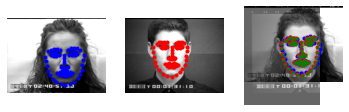

In [64]:
import matplotlib.cm as cm 

# Open images...
target_X_img = cv2.imread(all_images[0],0)
input_Y_img = cv2.imread(all_images[300],0)

# Landmark points - same number and order!
# l eye, r eye, nose tip, l mouth, r mouth
X_pts = np.asarray(lan)
Y_pts = np.asarray(lan1)

# Calculate transform via procrustes...

r,s,tr, d= opa(X_pts,Y_pts)

# Build and apply transform matrix...
# Note: for affine need 2x3 (a,b,c,d,e,f) form
R = np.eye(3)
R[0:2,0:2] = r
S = np.eye(3) * s
S[2,2] = 1
t = np.eye(3)
t[0:2,2] = tr
M = np.dot(np.dot(R,S),t.T).T
tr_Y_img = cv2.warpAffine(input_Y_img,M[0:2,:],(490,640))

#transform deberia hacer el a[1] = a[1].dot(r) * s + t
Z_pts = Y_pts.dot(r) * s + tr
# Confirm points...
aY_pts = np.hstack((Y_pts,np.array(([np.ones(68)])).T))
tr_Y_pts = np.dot(M,aY_pts.T).T

# Show result - input transformed and superimposed on target...
plt.figure() 
plt.subplot(1,3,1)
plt.imshow(target_X_img,cmap=cm.gray)
plt.plot(X_pts[:,0],X_pts[:,1],'bo',markersize=3)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(input_Y_img,cmap=cm.gray)
plt.plot(Y_pts[:,0],Y_pts[:,1],'ro',markersize=3)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(target_X_img,cmap=cm.gray)
plt.imshow(tr_Y_img,alpha=0.6,cmap=cm.gray)
plt.plot(X_pts[:,0],X_pts[:,1],'bo',markersize=3) 
plt.plot(Z_pts[:,0],Z_pts[:,1],'ro',markersize=3) # same as...
plt.plot(tr_Y_pts[:,0],tr_Y_pts[:,1],'gx',markersize=3)
plt.axis('off')
plt.show()

In [ ]:
#Ahora hay uque hacerlo para todas las imagenes y ya estamos listos para TV transform (si usamos procustres generalizado es mejor porque vamos a usar la dhape + efectiva (- error))

### Ahora lo hacemos con todas las imagenes y guardamos imagenes y textura

In [10]:

even = np.asarray(my_landmarks.iloc[0][::2] )
odds = np.asarray( my_landmarks.iloc[0][1::2] )
target_X_img = cv2.imread(all_images[0],0)
lan =[]
for (a, b) in zip(even, odds):
    lan.append(np.asarray([a,b]))

transformed_landmarks_total = []

for i in range(0, len(my_landmarks)):
    even1 = np.asarray(my_landmarks.iloc[i][::2] )
    odds1 = np.asarray( my_landmarks.iloc[i][1::2] )
    lan1 =[]
    for (a, b) in zip(even1, odds1):
        lan1.append(np.asarray([a,b]))
    
    X_pts = np.asarray(lan)
    Y_pts = np.asarray(lan1)
    
    input_Y_img = cv2.imread(all_images[i])
    
    r,s,tr, d= opa(X_pts,Y_pts)

    
    # Build and apply transform matrix...
    # Note: for affine need 2x3 (a,b,c,d,e,f) form
    R = np.eye(3)
    R[0:2,0:2] = r
    S = np.eye(3) * s
    S[2,2] = 1
    t = np.eye(3)
    t[0:2,2] = tr
    M = np.dot(np.dot(R,S),t.T).T
    tr_Y_img = cv2.warpAffine(input_Y_img,M[0:2,:],(700,700))

    
    #transform deberia hacer el a[1] = a[1].dot(r) * s + t
    Z_pts = Y_pts.dot(r) * s + tr
 
   

    transformed_landmarks_total.append(Z_pts)
    filename = 'warped_image_procustres_'+ str(i) + '.png'
    path = '../ck+warped'
    cv2.imwrite(os.path.join(path , filename), tr_Y_img)
  
      
transformed_landmarks_total = np.asarray(transformed_landmarks_total) 

In [9]:
transformed_landmarks_total =transformed_landmarks_total.flatten().reshape((965,136))
transformed_landmarks_total.shape

my_df = pd.DataFrame(transformed_landmarks_total)
my_df.to_csv('transformed_landmarks_procustres_total.csv',header = False, index= False)

In [ ]:
Vamos a hacerlo con el general que da el error más chico

In [9]:

even = np.asarray(my_landmarks.iloc[0][::2] )
odds = np.asarray( my_landmarks.iloc[0][1::2] )
target_X_img = cv2.imread(all_images[0],0)
lan =[]
for (a, b) in zip(even, odds):
    lan.append(np.asarray([a,b]))

transformed_landmarks_total = []
lans  =[]

for i in range(0, len(my_landmarks)):
    even1 = np.asarray(my_landmarks.iloc[i][::2] )
    odds1 = np.asarray( my_landmarks.iloc[i][1::2] )
    lan1 =[]
    for (a, b) in zip(even1, odds1):
        lan1.append(np.asarray([a,b]))
    
    
    
    Y_pts = np.asarray(lan1)
    lans.append(Y_pts)

lans = np.asarray(lans)

rV,sV,trV, dV= gpa(lans)
M_index =  np.argmin(dV)

for i in range(0, len(my_landmarks)):   
    input_Y_img = cv2.imread(all_images[i])
    Y_pts = lans[i]
    
    r = rV[M_index]
    s = sV[M_index]
    tr = trV[M_index]



    
    # Build and apply transform matrix...
    # Note: for affine need 2x3 (a,b,c,d,e,f) form
    R = np.eye(3)
    R[0:2,0:2] = r
    S = np.eye(3) * s
    S[2,2] = 1
    t = np.eye(3)
    t[0:2,2] = tr
    M = np.dot(np.dot(R,S),t.T).T
    tr_Y_img = cv2.warpAffine(input_Y_img,M[0:2,:],(600,600))

    
    #transform deberia hacer el a[1] = a[1].dot(r) * s + t
    Z_pts = Y_pts.dot(r) * s + tr
 
   

    transformed_landmarks_total.append(Z_pts)
    filename = 'warped_image_gen_rocustres_'+ str(i) + '.png'
    path = '../ck+warped'
    cv2.imwrite(os.path.join(path , filename), tr_Y_img)
  
      
transformed_landmarks_total = np.asarray(transformed_landmarks_total) 

In [10]:
transformed_landmarks_total =transformed_landmarks_total.flatten().reshape((965,136))
transformed_landmarks_total.shape

my_df = pd.DataFrame(transformed_landmarks_total)
my_df.to_csv('transformed_landmarks_gen_procustres_total.csv',header = False, index= False)

In [ ]:

def gpa_out(a):
    g = gpa(a, -1) 
    D = [avg(a)]
    for i in range(len(a)):
        D.append(a[i].dot(g[0][i]) * g[1][i] + g[2][i])
    return D, sum(g[3])/len(a), True 
plt(*gpa_out([arr1, arr2]))

In [ ]:
Ahora (con las de gen_procustres por ahora) vamos a hacer el TV scree

In [ ]:
Para eso hay que resoler un sistema SOCP

In [ ]:
def align_to_shape(image, labels, target, extend=1.0, rotate=False):
  image = np.array(image)
  labels = np.array(labels).astype(np.float32)
  target = np.array(target).astype(np.float32)
  m, _ = cv2.estimateAffinePartial2D(labels, target)
  image_t = cv2.warpAffine(image, m, (128, 128))
  labels_t = np.dot(labels, m[:,:2].T) + m[np.newaxis,:,2]
  return image_t, labels_t